In [1]:
# ============================================================================
# IMPROVED SKIN CANCER DETECTION - COMPLETE OPTIMIZED CODE
# Expected Accuracy: 75-85%
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

print("="*80)
print("IMPROVED SKIN CANCER DETECTION - COMPLETE CODE")
print("="*80)
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print("="*80)

d:\Cancerdetection\.venv\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.0) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


IMPROVED SKIN CANCER DETECTION - COMPLETE CODE
TensorFlow version: 2.20.0
GPU Available: False


In [2]:
# ============================================================================
# CONFIGURATION
# ============================================================================

CONFIG = {
    'base_dir': r"D:\Cancerdetection",
    'img_size': (224, 224),  # OPTIMIZED: 224x224 is best balance of speed/accuracy
    'batch_size': 32,  # Back to 32 for faster training at 224x224
    'epochs': 50,
    'initial_lr': 0.0001,
    'fine_tune_lr': 0.000005,  # Much lower for fine-tuning
    'fine_tune_epochs': 25,
    'validation_split': 0.15,
    'test_split': 0.2,
    'random_state': 42,
    'balance_method': 'undersample',  # 'undersample', 'oversample', or 'class_weights'
    'undersample_ratio': 0.3,  # Keep 30% of majority class (CRITICAL FOR ACCURACY)
    
    # OPTIONAL: Set to True to use larger images (slower but potentially +2-3% accuracy)
    'use_larger_images': False,  # Change to True if you have powerful GPU and time
}

In [3]:
# ============================================================================
# STEP 1: LOAD DATA
# ============================================================================

print("\n" + "="*80)
print("STEP 1: LOADING DATA")
print("="*80)

base_skin_dir = CONFIG['base_dir']

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

print(f"Found {len(imageid_path_dict)} images")

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

print(f"\nDataset Info:")
print(f"  Total samples: {len(skin_df)}")
print(f"  Number of classes: {skin_df['cell_type'].nunique()}")

print("\nOriginal class distribution:")
print(skin_df['cell_type'].value_counts())

# Fill missing values
skin_df['age'].fillna(skin_df['age'].mean(), inplace=True)


STEP 1: LOADING DATA
Found 10015 images

Dataset Info:
  Total samples: 10015
  Number of classes: 7

Original class distribution:
cell_type
Melanocytic nevi                 6705
Melanoma                         1113
Benign keratosis-like lesions    1099
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: count, dtype: int64


In [4]:
# ============================================================================
# STEP 2: BALANCE DATASET (CRITICAL FOR ACCURACY)
# ============================================================================

print("\n" + "="*80)
print("STEP 2: BALANCING DATASET")
print("="*80)

if CONFIG['balance_method'] == 'undersample':
    print("Using UNDERSAMPLING strategy...")
    
    # Find majority and minority classes
    class_counts = skin_df['cell_type'].value_counts()
    print(f"\nClass counts before balancing:")
    print(class_counts)
    
    # Calculate target count (median or custom ratio)
    max_count = class_counts.max()
    target_count = int(max_count * CONFIG['undersample_ratio'])
    
    print(f"\nTarget samples per class: {target_count}")
    
    balanced_dfs = []
    for cell_type in skin_df['cell_type'].unique():
        class_df = skin_df[skin_df['cell_type'] == cell_type]
        
        if len(class_df) > target_count:
            # Undersample majority class
            class_df_sampled = class_df.sample(n=target_count, random_state=42)
            print(f"  {cell_type}: {len(class_df)} → {target_count} (undersampled)")
        else:
            # Keep minority class as is (or oversample if needed)
            class_df_sampled = class_df
            print(f"  {cell_type}: {len(class_df)} (kept all)")
        
        balanced_dfs.append(class_df_sampled)
    
    skin_df_balanced = pd.concat(balanced_dfs, ignore_index=True)
    
    print(f"\nDataset after balancing:")
    print(f"  Total samples: {len(skin_df_balanced)}")
    print(f"  Class distribution:")
    print(skin_df_balanced['cell_type'].value_counts())
    
    # Use balanced dataset
    skin_df = skin_df_balanced

elif CONFIG['balance_method'] == 'oversample':
    print("Using OVERSAMPLING strategy...")
    
    class_counts = skin_df['cell_type'].value_counts()
    target_count = class_counts.max()
    
    print(f"\nTarget samples per class: {target_count}")
    
    balanced_dfs = []
    for cell_type in skin_df['cell_type'].unique():
        class_df = skin_df[skin_df['cell_type'] == cell_type]
        
        if len(class_df) < target_count:
            # Oversample minority class with replacement
            samples_needed = target_count - len(class_df)
            oversampled = class_df.sample(n=samples_needed, replace=True, random_state=42)
            class_df_balanced = pd.concat([class_df, oversampled], ignore_index=True)
            print(f"  {cell_type}: {len(class_df)} → {target_count} (oversampled)")
        else:
            class_df_balanced = class_df
            print(f"  {cell_type}: {len(class_df)} (kept all)")
        
        balanced_dfs.append(class_df_balanced)
    
    skin_df_balanced = pd.concat(balanced_dfs, ignore_index=True)
    skin_df = skin_df_balanced
    
    print(f"\nDataset after balancing:")
    print(skin_df['cell_type'].value_counts())

else:
    print("Using CLASS WEIGHTS strategy (no resampling)...")


STEP 2: BALANCING DATASET
Using UNDERSAMPLING strategy...

Class counts before balancing:
cell_type
Melanocytic nevi                 6705
Melanoma                         1113
Benign keratosis-like lesions    1099
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: count, dtype: int64

Target samples per class: 2011
  Benign keratosis-like lesions: 1099 (kept all)
  Melanocytic nevi: 6705 → 2011 (undersampled)
  Dermatofibroma: 115 (kept all)
  Melanoma: 1113 (kept all)
  Vascular lesions: 142 (kept all)
  Basal cell carcinoma: 514 (kept all)
  Actinic keratoses: 327 (kept all)

Dataset after balancing:
  Total samples: 5321
  Class distribution:
cell_type
Melanocytic nevi                 2011
Melanoma                         1113
Benign keratosis-like lesions    1099
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142


In [5]:
# ============================================================================
# STEP 3: LOAD AND PREPROCESS IMAGES
# ============================================================================

print("\n" + "="*80)
print("STEP 3: LOADING IMAGES")
print("="*80)

# Adjust image size based on config
if CONFIG.get('use_larger_images', False):
    img_size = (300, 300)
    print("Using larger 300x300 images (slower but more detailed)")
else:
    img_size = CONFIG['img_size']
    print("Using standard 224x224 images (faster, good accuracy)")

print(f"Resizing images to {img_size[0]}x{img_size[1]}...")
print("This may take a few minutes...")

skin_df['image'] = skin_df['path'].map(
    lambda x: np.asarray(Image.open(x).resize(img_size))
)

print("✓ Images loaded successfully!")



STEP 3: LOADING IMAGES
Using standard 224x224 images (faster, good accuracy)
Resizing images to 224x224...
This may take a few minutes...
✓ Images loaded successfully!


In [6]:
# ============================================================================
# STEP 4: PREPARE DATA FOR TRAINING
# ============================================================================

print("\n" + "="*80)
print("STEP 4: PREPARING DATA SPLITS")
print("="*80)

X = np.array(skin_df['image'].tolist())
y = np.array(skin_df['cell_type_idx'])

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Split with stratification
x_train_full, x_test, y_train_full, y_test = train_test_split(
    X, y, test_size=CONFIG['test_split'], random_state=CONFIG['random_state'], stratify=y
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=CONFIG['validation_split'], 
    random_state=42, stratify=y_train_full
)

print(f"\nSplit sizes:")
print(f"  Training: {x_train.shape[0]} samples")
print(f"  Validation: {x_val.shape[0]} samples")
print(f"  Testing: {x_test.shape[0]} samples")



STEP 4: PREPARING DATA SPLITS
X shape: (5321, 224, 224, 3)
y shape: (5321,)

Split sizes:
  Training: 3617 samples
  Validation: 639 samples
  Testing: 1065 samples


In [7]:
# ============================================================================
# STEP 5: NORMALIZE DATA
# ============================================================================

print("\n" + "="*80)
print("STEP 5: NORMALIZING DATA")
print("="*80)

from tensorflow.keras.applications.efficientnet import preprocess_input

x_train = preprocess_input(x_train.astype('float32'))
x_val = preprocess_input(x_val.astype('float32'))
x_test = preprocess_input(x_test.astype('float32'))

print(f"✓ Data normalized")
print(f"  Train range: [{x_train.min():.3f}, {x_train.max():.3f}]")


STEP 5: NORMALIZING DATA
✓ Data normalized
  Train range: [0.000, 255.000]


In [8]:
# ============================================================================
# STEP 6: ONE-HOT ENCODE LABELS
# ============================================================================

print("\n" + "="*80)
print("STEP 6: ENCODING LABELS")
print("="*80)

cat = pd.Categorical(skin_df['cell_type'])
class_names = cat.categories.tolist()
num_classes = len(class_names)

print(f"Classes: {class_names}")
print(f"Number of classes: {num_classes}")

y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)



STEP 6: ENCODING LABELS
Classes: ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Dermatofibroma', 'Melanocytic nevi', 'Melanoma', 'Vascular lesions']
Number of classes: 7


In [9]:
# ============================================================================
# STEP 7: COMPUTE CLASS WEIGHTS
# ============================================================================

print("\n" + "="*80)
print("STEP 7: COMPUTING CLASS WEIGHTS")
print("="*80)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:")
for i, (name, weight) in enumerate(zip(class_names, class_weights)):
    print(f"  {name}: {weight:.2f}")



STEP 7: COMPUTING CLASS WEIGHTS
Class weights:
  Actinic keratoses: 2.32
  Basal cell carcinoma: 1.48
  Benign keratosis-like lesions: 0.69
  Dermatofibroma: 6.62
  Melanocytic nevi: 0.38
  Melanoma: 0.68
  Vascular lesions: 5.33


In [10]:
# ============================================================================
# STEP 8: CREATE DATA GENERATORS WITH BETTER AUGMENTATION
# ============================================================================

print("\n" + "="*80)
print("STEP 8: CREATING DATA GENERATORS")
print("="*80)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Enhanced augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator()

batch_size = CONFIG['batch_size']

train_generator = train_datagen.flow(
    x_train, y_train_cat,
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_test_datagen.flow(
    x_val, y_val_cat,
    batch_size=batch_size,
    shuffle=False
)

test_generator = val_test_datagen.flow(
    x_test, y_test_cat,
    batch_size=batch_size,
    shuffle=False
)

steps_per_epoch = len(x_train) // batch_size
validation_steps = len(x_val) // batch_size
test_steps = int(np.ceil(len(x_test) / batch_size))

print("✓ Data generators created")
print(f"  Steps per epoch: {steps_per_epoch}")
print(f"  Validation steps: {validation_steps}")



STEP 8: CREATING DATA GENERATORS
✓ Data generators created
  Steps per epoch: 113
  Validation steps: 19


In [11]:
# ============================================================================
# STEP 9: BUILD IMPROVED MODEL
# ============================================================================

print("\n" + "="*80)
print("STEP 9: BUILDING IMPROVED MODEL")
print("="*80)

# Choose model based on image size
if img_size[0] >= 300:
    print("Using EfficientNetB3 (better for larger images)")
    from tensorflow.keras.applications import EfficientNetB3
    base_model = EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size[0], img_size[1], 3)
    )
else:
    print("Using EfficientNetB0 (optimized for 224x224)")
    from tensorflow.keras.applications import EfficientNetB0
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size[0], img_size[1], 3)
    )

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
], name='EfficientNetB3_SkinCancer')

print(f"✓ EfficientNetB3 loaded")
print(f"  Total base layers: {len(base_model.layers)}")
print(f"  Base trainable: {base_model.trainable}")

model.summary()



STEP 9: BUILDING IMPROVED MODEL
Using EfficientNetB0 (optimized for 224x224)
✓ EfficientNetB3 loaded
  Total base layers: 238
  Base trainable: False


Model: "EfficientNetB3_SkinCancer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,877,738 (18.61 MB)

 Trainable params: 824,583 (3.15 MB)

 Non-trainable params: 4,053,155 (15.46 MB)

In [12]:
# ============================================================================
# STEP 10: COMPILE MODEL
# ============================================================================

print("\n" + "="*80)
print("STEP 10: COMPILING MODEL")
print("="*80)

model.compile(
    optimizer=Adam(learning_rate=CONFIG['initial_lr']),
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             keras.metrics.AUC(name='auc'),
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

print("✓ Model compiled")


STEP 10: COMPILING MODEL
✓ Model compiled


In [13]:
# ============================================================================
# STEP 11: SETUP CALLBACKS
# ============================================================================

print("\n" + "="*80)
print("STEP 11: SETTING UP CALLBACKS")
print("="*80)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    verbose=1,
    factor=0.3,
    min_lr=1e-7
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model_improved.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    mode='max'
)

callbacks = [reduce_lr, early_stop, checkpoint]

print("✓ Callbacks configured")



STEP 11: SETTING UP CALLBACKS
✓ Callbacks configured


In [14]:
# ============================================================================
# STEP 12: TRAIN MODEL - PHASE 1 (FROZEN BASE)
# ============================================================================

print("\n" + "="*80)
print("STEP 12: TRAINING - PHASE 1 (FROZEN BASE)")
print("="*80)
print("This will take 30-60 minutes...")

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=CONFIG['epochs'],
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Phase 1 training complete!")


STEP 12: TRAINING - PHASE 1 (FROZEN BASE)
This will take 30-60 minutes...
Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.1495 - auc: 0.5208 - loss: 3.6113 - precision: 0.1570 - recall: 0.0413
Epoch 1: val_accuracy improved from None to 0.32895, saving model to best_model_improved.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 104s 831ms/step - accuracy: 0.1702 - auc: 0.5450 - loss: 3.6057 - precision: 0.1709 - recall: 0.0410 - val_accuracy: 0.3289 - val_auc: 0.6370 - val_loss: 3.0988 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:04 576ms/step - accuracy: 0.0938 - auc: 0.4862 - loss: 3.2514 - precision: 0.1429 - recall: 0.0312
Epoch 2: val_accuracy improved from 0.32895 to 0.33059, saving model to best_model_improved.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.0938 - auc: 0.4862 - loss: 3.2514 - precision: 0.1429 - recall: 0.0312 - val_accuracy: 0.3306 - val_auc: 0.6380 - val_loss: 3.0975 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.2107 - auc: 0.6006 - loss: 3.3259 - precision: 0.2809 - recall: 0.0598
Epoch 3: val_accuracy improved from 0.33059 to 0.35691, saving model to best_model_improved.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 84s 743ms/step - accuracy: 0.2326 - auc: 0.6181 - loss: 3.3115 - precision: 0.3181 - recall: 0.0678 - val_accuracy: 0.3569 - val_auc: 0.6885 - val_loss: 2.9884 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/50
  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:06 594ms/step - accuracy: 0.2188 - auc: 0.7013 - loss: 2.7588 - precision: 0.2500 - recall: 0.0625
Epoch 4: val_accuracy did not improve from 0.35691
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.2188 - auc: 0.7013 - loss: 2.7588 - precision: 0.2500 - recall: 0.0625 - val_accuracy: 0.3569 - val_auc: 0.6888 - val_loss: 2.9878 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.2459 - auc: 0.6317 - loss: 3.2748 - precision: 0.2868 - recall: 0.0661
Epoch 5: val_accuracy improved from 0.35691 to 0.35855, saving model to best_model_improved.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 87s 767ms/step - accuracy: 0.2424 - auc: 0.6361 - loss: 3.2127 - precision: 0.2978 - recall: 0.0686 - val_accuracy: 0.3586 - val_auc: 0.7110 - val_loss: 2.9275 - val_precision: 1.0000 - val_recall: 0.0148 - learning_rate: 1.0000e-04
Epoch 6/50
  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:01 548ms/step - accuracy: 0.1250 - auc: 0.4945 - loss: 3.5443 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6: val_accuracy did not improve from 0.35855
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - accuracy: 0.1250 - auc: 0.4945 - loss: 3.5443 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3553 - val_auc: 0.7119 - val_loss: 2.9264 - val_precision: 1.0000 - val_recall: 0.0148 - learning_rate: 1.0000e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.2811 - auc: 0.6583 - loss: 3.1183 - precision: 0.3883 - recall: 0.0887
Epoch 7: val_accuracy did not improve from 0.35855
113/113 ━━━━━━━━━━━━━━━━━━━━ 85s 752ms/step - accuracy: 0.2803 - auc: 0.6666 -

113/113 ━━━━━━━━━━━━━━━━━━━━ 83s 735ms/step - accuracy: 0.2932 - auc: 0.6862 - loss: 3.0187 - precision: 0.4138 - recall: 0.1038 - val_accuracy: 0.3734 - val_auc: 0.7573 - val_loss: 2.8201 - val_precision: 0.7288 - val_recall: 0.1414 - learning_rate: 1.0000e-04
Epoch 10/50
  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:09 617ms/step - accuracy: 0.3125 - auc: 0.6833 - loss: 3.1739 - precision: 0.4000 - recall: 0.0625
Epoch 10: val_accuracy improved from 0.37336 to 0.37664, saving model to best_model_improved.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.3125 - auc: 0.6833 - loss: 3.1739 - precision: 0.4000 - recall: 0.0625 - val_accuracy: 0.3766 - val_auc: 0.7571 - val_loss: 2.8196 - val_precision: 0.7355 - val_recall: 0.1464 - learning_rate: 1.0000e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.3090 - auc: 0.7029 - loss: 2.9756 - precision: 0.4308 - recall: 0.1282
Epoch 11: val_accuracy did not improve from 0.37664
113/113 ━━━━━━━━━━━━━━━━━━━━ 79s 703ms/step - accuracy: 0.3082 - auc: 0.7036 - loss: 3.0071 - precision: 0.4513 - recall: 0.1305 - val_accuracy: 0.3766 - val_auc: 0.7742 - val_loss: 2.7837 - val_precision: 0.6879 - val_recall: 0.1595 - learning_rate: 1.0000e-04
Epoch 12/50
  1/113 ━━━━━━━━━━━━━━━━━━━━ 57s 517ms/step - accuracy: 0.2188 - auc: 0.7338 - loss: 2.2817 - precision: 0.5455 - recall: 0.1875
Epoch 12: val_accuracy did not improve from 0.37664
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.2188 - auc: 0.7338 - loss: 2.2817 -

113/113 ━━━━━━━━━━━━━━━━━━━━ 84s 744ms/step - accuracy: 0.3105 - auc: 0.7203 - loss: 2.9186 - precision: 0.4505 - recall: 0.1244 - val_accuracy: 0.4046 - val_auc: 0.7842 - val_loss: 2.7447 - val_precision: 0.6983 - val_recall: 0.2056 - learning_rate: 1.0000e-04
Epoch 14/50
  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:01 548ms/step - accuracy: 0.4062 - auc: 0.7944 - loss: 3.0181 - precision: 0.7500 - recall: 0.1875
Epoch 14: val_accuracy did not improve from 0.40461
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.4062 - auc: 0.7944 - loss: 3.0181 - precision: 0.7500 - recall: 0.1875 - val_accuracy: 0.4046 - val_auc: 0.7844 - val_loss: 2.7435 - val_precision: 0.7022 - val_recall: 0.2056 - learning_rate: 1.0000e-04
Epoch 15/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.3381 - auc: 0.7302 - loss: 2.8308 - precision: 0.4756 - recall: 0.1429
Epoch 15: val_accuracy improved from 0.40461 to 0.41283, saving model to best_model_improved.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 83s 737ms/step - accuracy: 0.3333 - auc: 0.7308 - loss: 2.8865 - precision: 0.4714 - recall: 0.1448 - val_accuracy: 0.4128 - val_auc: 0.7893 - val_loss: 2.7320 - val_precision: 0.6977 - val_recall: 0.1974 - learning_rate: 1.0000e-04
Epoch 16/50
  1/113 ━━━━━━━━━━━━━━━━━━━━ 58s 518ms/step - accuracy: 0.2500 - auc: 0.7627 - loss: 2.9826 - precision: 0.3077 - recall: 0.1250
Epoch 16: val_accuracy did not improve from 0.41283
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.2500 - auc: 0.7627 - loss: 2.9826 - precision: 0.3077 - recall: 0.1250 - val_accuracy: 0.4095 - val_auc: 0.7893 - val_loss: 2.7318 - val_precision: 0.6977 - val_recall: 0.1974 - learning_rate: 1.0000e-04
Epoch 17/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.3469 - auc: 0.7495 - loss: 2.7935 - precision: 0.4840 - recall: 0.1494
Epoch 17: val_accuracy improved from 0.41283 to 0.41612, saving model to best_model_improved.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 81s 715ms/step - accuracy: 0.3372 - auc: 0.7430 - loss: 2.7971 - precision: 0.4712 - recall: 0.1481 - val_accuracy: 0.4161 - val_auc: 0.8010 - val_loss: 2.6939 - val_precision: 0.6720 - val_recall: 0.2056 - learning_rate: 1.0000e-04
Epoch 18/50
  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:00 538ms/step - accuracy: 0.4062 - auc: 0.7783 - loss: 2.8162 - precision: 0.6000 - recall: 0.1875
Epoch 18: val_accuracy did not improve from 0.41612
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.4062 - auc: 0.7783 - loss: 2.8162 - precision: 0.6000 - recall: 0.1875 - val_accuracy: 0.4145 - val_auc: 0.8009 - val_loss: 2.6946 - val_precision: 0.6703 - val_recall: 0.2039 - learning_rate: 1.0000e-04
Epoch 19/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.3739 - auc: 0.7521 - loss: 2.8013 - precision: 0.4912 - recall: 0.1629
Epoch 19: val_accuracy did not improve from 0.41612
113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 727ms/step - accuracy: 0.3643 - auc: 0.7523 - loss: 2.7751

113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - accuracy: 0.2500 - auc: 0.7840 - loss: 3.5081 - precision: 0.3125 - recall: 0.1562 - val_accuracy: 0.4178 - val_auc: 0.8008 - val_loss: 2.6891 - val_precision: 0.6619 - val_recall: 0.2286 - learning_rate: 1.0000e-04
Epoch 23/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.3516 - auc: 0.7559 - loss: 2.7847 - precision: 0.5111 - recall: 0.1799
Epoch 23: val_accuracy did not improve from 0.41776
113/113 ━━━━━━━━━━━━━━━━━━━━ 86s 761ms/step - accuracy: 0.3623 - auc: 0.7606 - loss: 2.7229 - precision: 0.5051 - recall: 0.1805 - val_accuracy: 0.4178 - val_auc: 0.8084 - val_loss: 2.6588 - val_precision: 0.6714 - val_recall: 0.2352 - learning_rate: 1.0000e-04
Epoch 24/50
  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:05 587ms/step - accuracy: 0.2812 - auc: 0.7321 - loss: 2.8811 - precision: 0.5455 - recall: 0.1875
Epoch 24: val_accuracy improved from 0.41776 to 0.42105, saving model to best_model_improved.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.2812 - auc: 0.7321 - loss: 2.8811 - precision: 0.5455 - recall: 0.1875 - val_accuracy: 0.4211 - val_auc: 0.8088 - val_loss: 2.6574 - val_precision: 0.6714 - val_recall: 0.2352 - learning_rate: 1.0000e-04
Epoch 25/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.3792 - auc: 0.7772 - loss: 2.6423 - precision: 0.5264 - recall: 0.2042
Epoch 25: val_accuracy did not improve from 0.42105
113/113 ━━━━━━━━━━━━━━━━━━━━ 87s 773ms/step - accuracy: 0.3749 - auc: 0.7756 - loss: 2.6695 - precision: 0.5118 - recall: 0.1939 - val_accuracy: 0.4211 - val_auc: 0.8045 - val_loss: 2.6702 - val_precision: 0.6335 - val_recall: 0.2303 - learning_rate: 1.0000e-04
Epoch 26/50
  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:00 540ms/step - accuracy: 0.3125 - auc: 0.7839 - loss: 3.0978 - precision: 0.2500 - recall: 0.0938
Epoch 26: val_accuracy did not improve from 0.42105
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.3125 - auc: 0.7839 - loss: 3.0978 

113/113 ━━━━━━━━━━━━━━━━━━━━ 86s 759ms/step - accuracy: 0.3869 - auc: 0.7831 - loss: 2.6721 - precision: 0.5422 - recall: 0.2045 - val_accuracy: 0.4293 - val_auc: 0.8117 - val_loss: 2.6397 - val_precision: 0.6667 - val_recall: 0.2434 - learning_rate: 1.0000e-04
Epoch 28/50
  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:02 558ms/step - accuracy: 0.4062 - auc: 0.7408 - loss: 2.7014 - precision: 0.5385 - recall: 0.2188
Epoch 28: val_accuracy did not improve from 0.42928
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.4062 - auc: 0.7408 - loss: 2.7014 - precision: 0.5385 - recall: 0.2188 - val_accuracy: 0.4276 - val_auc: 0.8119 - val_loss: 2.6388 - val_precision: 0.6682 - val_recall: 0.2451 - learning_rate: 1.0000e-04
Epoch 29/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.3929 - auc: 0.7938 - loss: 2.6203 - precision: 0.5229 - recall: 0.2073
Epoch 29: val_accuracy improved from 0.42928 to 0.44408, saving model to best_model_improved.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 85s 751ms/step - accuracy: 0.3958 - auc: 0.7910 - loss: 2.6040 - precision: 0.5285 - recall: 0.2095 - val_accuracy: 0.4441 - val_auc: 0.8166 - val_loss: 2.6197 - val_precision: 0.6538 - val_recall: 0.2516 - learning_rate: 1.0000e-04
Epoch 30/50
  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:02 558ms/step - accuracy: 0.4375 - auc: 0.8469 - loss: 2.3309 - precision: 0.5882 - recall: 0.3125
Epoch 30: val_accuracy did not improve from 0.44408
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - accuracy: 0.4375 - auc: 0.8469 - loss: 2.3309 - precision: 0.5882 - recall: 0.3125 - val_accuracy: 0.4441 - val_auc: 0.8168 - val_loss: 2.6196 - val_precision: 0.6553 - val_recall: 0.2533 - learning_rate: 1.0000e-04
Epoch 31/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.4122 - auc: 0.8001 - loss: 2.5315 - precision: 0.5629 - recall: 0.2218
Epoch 31: val_accuracy did not improve from 0.44408
113/113 ━━━━━━━━━━━━━━━━━━━━ 84s 744ms/step - accuracy: 0.4117 - auc: 0.8010 - loss: 2.5633

113/113 ━━━━━━━━━━━━━━━━━━━━ 85s 751ms/step - accuracy: 0.4000 - auc: 0.7953 - loss: 2.6033 - precision: 0.5379 - recall: 0.2276 - val_accuracy: 0.4490 - val_auc: 0.8209 - val_loss: 2.6019 - val_precision: 0.6332 - val_recall: 0.2697 - learning_rate: 1.0000e-04
Epoch 34/50
  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:05 583ms/step - accuracy: 0.4062 - auc: 0.7920 - loss: 2.3070 - precision: 0.5294 - recall: 0.2812
Epoch 34: val_accuracy did not improve from 0.44901
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.4062 - auc: 0.7920 - loss: 2.3070 - precision: 0.5294 - recall: 0.2812 - val_accuracy: 0.4474 - val_auc: 0.8211 - val_loss: 2.6014 - val_precision: 0.6342 - val_recall: 0.2681 - learning_rate: 1.0000e-04
Epoch 35/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.4051 - auc: 0.7987 - loss: 2.5481 - precision: 0.5426 - recall: 0.2218
Epoch 35: val_accuracy did not improve from 0.44901
113/113 ━━━━━━━━━━━━━━━━━━━━ 86s 757ms/step - accuracy: 0.4112 - auc: 0.8038 - loss: 2.5621

113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 723ms/step - accuracy: 0.4385 - auc: 0.8178 - loss: 2.4829 - precision: 0.5762 - recall: 0.2594 - val_accuracy: 0.4671 - val_auc: 0.8352 - val_loss: 2.5343 - val_precision: 0.6596 - val_recall: 0.3092 - learning_rate: 1.0000e-04
Epoch 42/50
  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:01 552ms/step - accuracy: 0.4688 - auc: 0.8145 - loss: 2.7937 - precision: 0.5263 - recall: 0.3125
Epoch 42: val_accuracy did not improve from 0.46711
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.4688 - auc: 0.8145 - loss: 2.7937 - precision: 0.5263 - recall: 0.3125 - val_accuracy: 0.4655 - val_auc: 0.8356 - val_loss: 2.5334 - val_precision: 0.6608 - val_recall: 0.3076 - learning_rate: 1.0000e-04
Epoch 43/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.4343 - auc: 0.8210 - loss: 2.4584 - precision: 0.5609 - recall: 0.2545
Epoch 43: val_accuracy improved from 0.46711 to 0.47204, saving model to best_model_improved.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 84s 741ms/step - accuracy: 0.4357 - auc: 0.8213 - loss: 2.4979 - precision: 0.5788 - recall: 0.2675 - val_accuracy: 0.4720 - val_auc: 0.8436 - val_loss: 2.4969 - val_precision: 0.6567 - val_recall: 0.2895 - learning_rate: 1.0000e-04
Epoch 44/50
  1/113 ━━━━━━━━━━━━━━━━━━━━ 59s 532ms/step - accuracy: 0.3438 - auc: 0.8140 - loss: 2.6188 - precision: 0.5833 - recall: 0.2188
Epoch 44: val_accuracy improved from 0.47204 to 0.47368, saving model to best_model_improved.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.3438 - auc: 0.8140 - loss: 2.6188 - precision: 0.5833 - recall: 0.2188 - val_accuracy: 0.4737 - val_auc: 0.8437 - val_loss: 2.4971 - val_precision: 0.6567 - val_recall: 0.2895 - learning_rate: 1.0000e-04
Epoch 45/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.4380 - auc: 0.8196 - loss: 2.4151 - precision: 0.5721 - recall: 0.2630
Epoch 45: val_accuracy did not improve from 0.47368
113/113 ━━━━━━━━━━━━━━━━━━━━ 85s 750ms/step - accuracy: 0.4391 - auc: 0.8202 - loss: 2.4561 - precision: 0.5763 - recall: 0.2644 - val_accuracy: 0.4720 - val_auc: 0.8410 - val_loss: 2.5059 - val_precision: 0.6471 - val_recall: 0.2895 - learning_rate: 1.0000e-04
Epoch 46/50
  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:03 563ms/step - accuracy: 0.5000 - auc: 0.8577 - loss: 2.5080 - precision: 0.6923 - recall: 0.2812
Epoch 46: val_accuracy did not improve from 0.47368
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.5000 - auc: 0.8577 - loss: 2.5080 

113/113 ━━━━━━━━━━━━━━━━━━━━ 81s 712ms/step - accuracy: 0.4455 - auc: 0.8301 - loss: 2.4168 - precision: 0.5812 - recall: 0.2695 - val_accuracy: 0.4786 - val_auc: 0.8453 - val_loss: 2.4857 - val_precision: 0.6339 - val_recall: 0.3076 - learning_rate: 3.0000e-05
Epoch 50/50
  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:08 614ms/step - accuracy: 0.4062 - auc: 0.8045 - loss: 2.4962 - precision: 0.4706 - recall: 0.2500
Epoch 50: val_accuracy did not improve from 0.47862
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.4062 - auc: 0.8045 - loss: 2.4962 - precision: 0.4706 - recall: 0.2500 - val_accuracy: 0.4786 - val_auc: 0.8452 - val_loss: 2.4866 - val_precision: 0.6339 - val_recall: 0.3076 - learning_rate: 3.0000e-05
Restoring model weights from the end of the best epoch: 49.

✓ Phase 1 training complete!


In [15]:
# ============================================================================
# STEP 13: FINE-TUNE MODEL - PHASE 2 (CAREFUL UNFREEZING)
# ============================================================================

print("\n" + "="*80)
print("STEP 13: FINE-TUNING - PHASE 2")
print("="*80)

# Unfreeze only top 30% of base model layers
base_model.trainable = True
total_layers = len(base_model.layers)
freeze_until = int(total_layers * 0.7)

for layer in base_model.layers[:freeze_until]:
    layer.trainable = False

trainable_layers = sum([1 for layer in base_model.layers if layer.trainable])
print(f"✓ Unfrozen top {trainable_layers} layers (out of {total_layers})")

# Recompile with very low learning rate
model.compile(
    optimizer=Adam(learning_rate=CONFIG['fine_tune_lr']),
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             keras.metrics.AUC(name='auc'),
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

print(f"✓ Recompiled with lr={CONFIG['fine_tune_lr']}")

# Stricter early stopping for fine-tuning
early_stop_finetune = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

callbacks_finetune = [reduce_lr, early_stop_finetune, checkpoint]

print("\nFine-tuning...")

history_fine = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=CONFIG['fine_tune_epochs'],
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=class_weight_dict,
    callbacks=callbacks_finetune,
    verbose=1
)

print("\n✓ Phase 2 fine-tuning complete!")


STEP 13: FINE-TUNING - PHASE 2
✓ Unfrozen top 72 layers (out of 238)
✓ Recompiled with lr=5e-06

Fine-tuning...
Epoch 1/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.3770 - auc: 0.7738 - loss: 2.8310 - precision: 0.4945 - recall: 0.1724
Epoch 1: val_accuracy did not improve from 0.47862
113/113 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.3679 - auc: 0.7730 - loss: 2.7828 - precision: 0.4939 - recall: 0.1685 - val_accuracy: 0.4786 - val_auc: 0.8462 - val_loss: 2.4854 - val_precision: 0.6357 - val_recall: 0.2928 - learning_rate: 5.0000e-06
Epoch 2/25
  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:28 789ms/step - accuracy: 0.3438 - auc: 0.7697 - loss: 2.6985 - precision: 0.5556 - recall: 0.1562
Epoch 2: val_accuracy did not improve from 0.47862
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - accuracy: 0.3438 - auc: 0.7697 - loss: 2.6985 - precision: 0.5556 - recall: 0.1562 - val_accuracy: 0.4786 - val_auc: 0.8460 - val_loss: 2.4854 - val_precision: 0.6357 - val_recall: 0.2928 - learning_

KeyboardInterrupt: 

In [ ]:
# ============================================================================
# STEP 14: EVALUATE MODEL
# ============================================================================

print("\n" + "="*80)
print("STEP 14: EVALUATING MODEL")
print("="*80)

# Load best model
model = keras.models.load_model('best_model_improved.h5')
print("✓ Best model loaded")

# Evaluate
test_results = model.evaluate(test_generator, steps=test_steps, verbose=0)

print(f"\n{'='*80}")
print("TEST RESULTS")
print(f"{'='*80}")
print(f"  Loss:      {test_results[0]:.4f}")
print(f"  Accuracy:  {test_results[1]:.4f} ({test_results[1]*100:.2f}%)")
print(f"  AUC:       {test_results[2]:.4f}")
print(f"  Precision: {test_results[3]:.4f}")
print(f"  Recall:    {test_results[4]:.4f}")
print(f"{'='*80}")


STEP 14: SETTING UP CALLBACKS
✓ Callbacks configured:
  - ReduceLROnPlateau
  - EarlyStopping
  - ModelCheckpoint


In [ ]:
# ============================================================================
# STEP 15: PLOT TRAINING HISTORY
# ============================================================================

print("\n" + "="*80)
print("STEP 15: PLOTTING TRAINING HISTORY")
print("="*80)

combined_history = {
    'accuracy': history.history['accuracy'] + history_fine.history['accuracy'],
    'val_accuracy': history.history['val_accuracy'] + history_fine.history['val_accuracy'],
    'loss': history.history['loss'] + history_fine.history['loss'],
    'val_loss': history.history['val_loss'] + history_fine.history['val_loss']
}

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, len(combined_history['accuracy']) + 1)
phase1_end = len(history.history['accuracy'])

# Accuracy
axs[0].plot(epochs_range, combined_history['accuracy'], label='Train', linewidth=2)
axs[0].plot(epochs_range, combined_history['val_accuracy'], label='Validation', linewidth=2)
axs[0].axvline(x=phase1_end, color='r', linestyle='--', label='Fine-tuning starts')
axs[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# Loss
axs[1].plot(epochs_range, combined_history['loss'], label='Train', linewidth=2)
axs[1].plot(epochs_range, combined_history['val_loss'], label='Validation', linewidth=2)
axs[1].axvline(x=phase1_end, color='r', linestyle='--', label='Fine-tuning starts')
axs[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_improved.png', dpi=300)
plt.show()

print("✓ History saved")


STEP 15: TRAINING MODEL - PHASE 1 (FROZEN BASE)
Training with frozen base model...
This may take 30-60 minutes depending on your hardware...
Epoch 1/45
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.2360 - auc: 0.6196 - loss: 12.0198 - precision: 0.3433
Epoch 1: val_accuracy improved from None to 0.48500, saving model to best_model_transfer.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 188s 790ms/step - accuracy: 0.2931 - auc: 0.6718 - loss: 11.2892 - precision: 0.6327 - val_accuracy: 0.4850 - val_auc: 0.8089 - val_loss: 9.8865 - val_precision: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/45
  1/225 ━━━━━━━━━━━━━━━━━━━━ 2:14 598ms/step - accuracy: 0.3438 - auc: 0.7023 - loss: 10.7452 - precision: 1.0000
Epoch 2: val_accuracy improved from 0.48500 to 0.49125, saving model to best_model_transfer.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.3438 - auc: 0.7023 - loss: 10.7452 - precision: 1.0000 - val_accuracy: 0.4913 - val_auc: 0.8091 - val_loss: 9.8759 - val_precision: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/45
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.4172 - auc: 0.7739 - loss: 9.4826 - precision: 0.8218
Epoch 3: val_accuracy did not improve from 0.49125
225/225 ━━━━━━━━━━━━━━━━━━━━ 155s 688ms/step - accuracy: 0.4284 - auc: 0.7838 - loss: 9.0641 - precision: 0.7380 - val_accuracy: 0.4613 - val_auc: 0.8500 - val_loss: 8.0554 - val_precision: 0.7398 - learning_rate: 1.0000e-04
Epoch 4/45
  1/225 ━━━━━━━━━━━━━━━━━━━━ 2:07 569ms/step - accuracy: 0.4375 - auc: 0.8503 - loss: 8.2329 - precision: 0.6250
Epoch 4: val_accuracy did not improve from 0.49125
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.4375 - auc: 0.8503 - loss: 8.2329 - precision: 0.6250 - val_accuracy: 0.4737 - val_auc: 0.8515 - val_loss: 8.0454 - val_precision: 0.7526 - learni

225/225 ━━━━━━━━━━━━━━━━━━━━ 155s 688ms/step - accuracy: 0.4837 - auc: 0.8284 - loss: 7.5037 - precision: 0.7595 - val_accuracy: 0.5200 - val_auc: 0.8756 - val_loss: 6.7658 - val_precision: 0.8566 - learning_rate: 1.0000e-04
Epoch 6/45
  1/225 ━━━━━━━━━━━━━━━━━━━━ 2:02 549ms/step - accuracy: 0.4688 - auc: 0.8009 - loss: 6.6068 - precision: 0.6429
Epoch 6: val_accuracy improved from 0.52000 to 0.52375, saving model to best_model_transfer.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.4688 - auc: 0.8009 - loss: 6.6068 - precision: 0.6429 - val_accuracy: 0.5238 - val_auc: 0.8783 - val_loss: 6.7518 - val_precision: 0.8652 - learning_rate: 1.0000e-04
Epoch 7/45
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.4949 - auc: 0.8391 - loss: 6.7026 - precision: 0.7484
Epoch 7: val_accuracy improved from 0.52375 to 0.60250, saving model to best_model_transfer.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 154s 683ms/step - accuracy: 0.5063 - auc: 0.8464 - loss: 6.4088 - precision: 0.7509 - val_accuracy: 0.6025 - val_auc: 0.9054 - val_loss: 5.7531 - val_precision: 0.8985 - learning_rate: 1.0000e-04
Epoch 8/45
  1/225 ━━━━━━━━━━━━━━━━━━━━ 2:11 585ms/step - accuracy: 0.4688 - auc: 0.8279 - loss: 5.6358 - precision: 0.5833
Epoch 8: val_accuracy improved from 0.60250 to 0.60875, saving model to best_model_transfer.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.4688 - auc: 0.8279 - loss: 5.6358 - precision: 0.5833 - val_accuracy: 0.6087 - val_auc: 0.9057 - val_loss: 5.7478 - val_precision: 0.8991 - learning_rate: 1.0000e-04
Epoch 9/45
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.5067 - auc: 0.8522 - loss: 5.7997 - precision: 0.7543
Epoch 9: val_accuracy did not improve from 0.60875
225/225 ━━━━━━━━━━━━━━━━━━━━ 163s 722ms/step - accuracy: 0.5224 - auc: 0.8599 - loss: 5.5567 - precision: 0.7421 - val_accuracy: 0.5800 - val_auc: 0.9037 - val_loss: 5.0484 - val_precision: 0.8365 - learning_rate: 1.0000e-04
Epoch 10/45
  1/225 ━━━━━━━━━━━━━━━━━━━━ 2:12 590ms/step - accuracy: 0.6875 - auc: 0.9106 - loss: 4.8070 - precision: 0.8750
Epoch 10: val_accuracy did not improve from 0.60875
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.6875 - auc: 0.9106 - loss: 4.8070 - precision: 0.8750 - val_accuracy: 0.5838 - val_auc: 0.9049 - val_loss: 5.0402 - val_precision: 0.8418 - learn

225/225 ━━━━━━━━━━━━━━━━━━━━ 193s 857ms/step - accuracy: 0.5288 - auc: 0.8658 - loss: 4.8884 - precision: 0.7262 - val_accuracy: 0.6200 - val_auc: 0.9172 - val_loss: 4.4266 - val_precision: 0.8364 - learning_rate: 1.0000e-04
Epoch 12/45
  1/225 ━━━━━━━━━━━━━━━━━━━━ 2:00 539ms/step - accuracy: 0.4688 - auc: 0.7904 - loss: 4.5366 - precision: 0.6364
Epoch 12: val_accuracy did not improve from 0.62000
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.4688 - auc: 0.7904 - loss: 4.5366 - precision: 0.6364 - val_accuracy: 0.6175 - val_auc: 0.9178 - val_loss: 4.4212 - val_precision: 0.8341 - learning_rate: 1.0000e-04
Epoch 13/45
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.5585 - auc: 0.8804 - loss: 4.4857 - precision: 0.7654
Epoch 13: val_accuracy did not improve from 0.62000
225/225 ━━━━━━━━━━━━━━━━━━━━ 152s 675ms/step - accuracy: 0.5612 - auc: 0.8842 - loss: 4.3539 - precision: 0.7622 - val_accuracy: 0.6037 - val_auc: 0.9154 - val_loss: 3.9936 - val_precision: 0.8188 - l

225/225 ━━━━━━━━━━━━━━━━━━━━ 153s 679ms/step - accuracy: 0.5630 - auc: 0.8871 - loss: 3.5981 - precision: 0.7428 - val_accuracy: 0.6275 - val_auc: 0.9288 - val_loss: 3.2527 - val_precision: 0.8176 - learning_rate: 1.0000e-04
Epoch 18/45
  1/225 ━━━━━━━━━━━━━━━━━━━━ 2:06 565ms/step - accuracy: 0.4375 - auc: 0.8610 - loss: 3.7387 - precision: 0.6667
Epoch 18: val_accuracy did not improve from 0.62750
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.4375 - auc: 0.8610 - loss: 3.7387 - precision: 0.6667 - val_accuracy: 0.6225 - val_auc: 0.9269 - val_loss: 3.2633 - val_precision: 0.8045 - learning_rate: 1.0000e-04
Epoch 19/45
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.5890 - auc: 0.8951 - loss: 3.3308 - precision: 0.7609
Epoch 19: val_accuracy did not improve from 0.62750
225/225 ━━━━━━━━━━━━━━━━━━━━ 178s 792ms/step - accuracy: 0.5821 - auc: 0.8918 - loss: 3.2737 - precision: 0.7572 - val_accuracy: 0.6263 - val_auc: 0.9313 - val_loss: 2.9948 - val_precision: 0.8086 - l

225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.5312 - auc: 0.8916 - loss: 4.3480 - precision: 0.5789 - val_accuracy: 0.6313 - val_auc: 0.9314 - val_loss: 2.9929 - val_precision: 0.8106 - learning_rate: 1.0000e-04
Epoch 21/45
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.5904 - auc: 0.8987 - loss: 3.0785 - precision: 0.7593
Epoch 21: val_accuracy did not improve from 0.63125
225/225 ━━━━━━━━━━━━━━━━━━━━ 152s 674ms/step - accuracy: 0.5889 - auc: 0.8986 - loss: 3.0217 - precision: 0.7611 - val_accuracy: 0.6050 - val_auc: 0.9173 - val_loss: 2.8654 - val_precision: 0.8115 - learning_rate: 1.0000e-04
Epoch 22/45
  1/225 ━━━━━━━━━━━━━━━━━━━━ 1:59 535ms/step - accuracy: 0.5625 - auc: 0.8869 - loss: 4.2472 - precision: 0.6667
Epoch 22: val_accuracy did not improve from 0.63125
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.5625 - auc: 0.8869 - loss: 4.2472 - precision: 0.6667 - val_accuracy: 0.6062 - val_auc: 0.9172 - val_loss: 2.8658 - val_precision: 0.8115 - lea

225/225 ━━━━━━━━━━━━━━━━━━━━ 158s 701ms/step - accuracy: 0.5897 - auc: 0.9051 - loss: 2.4867 - precision: 0.7596 - val_accuracy: 0.6600 - val_auc: 0.9403 - val_loss: 2.2525 - val_precision: 0.8247 - learning_rate: 1.0000e-04
Epoch 28/45
  1/225 ━━━━━━━━━━━━━━━━━━━━ 2:08 575ms/step - accuracy: 0.6250 - auc: 0.9425 - loss: 1.9776 - precision: 0.8261
Epoch 28: val_accuracy did not improve from 0.66000
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.6250 - auc: 0.9425 - loss: 1.9776 - precision: 0.8261 - val_accuracy: 0.6575 - val_auc: 0.9401 - val_loss: 2.2528 - val_precision: 0.8142 - learning_rate: 1.0000e-04
Epoch 29/45
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.5861 - auc: 0.9039 - loss: 2.4038 - precision: 0.7397
Epoch 29: val_accuracy did not improve from 0.66000
225/225 ━━━━━━━━━━━━━━━━━━━━ 156s 691ms/step - accuracy: 0.5943 - auc: 0.9041 - loss: 2.3506 - precision: 0.7499 - val_accuracy: 0.6413 - val_auc: 0.9266 - val_loss: 2.2227 - val_precision: 0.8360 - l

225/225 ━━━━━━━━━━━━━━━━━━━━ 154s 686ms/step - accuracy: 0.6271 - auc: 0.9195 - loss: 1.7389 - precision: 0.7702 - val_accuracy: 0.6612 - val_auc: 0.9420 - val_loss: 1.6644 - val_precision: 0.8495 - learning_rate: 5.0000e-05
Epoch 44/45
  1/225 ━━━━━━━━━━━━━━━━━━━━ 2:12 591ms/step - accuracy: 0.6250 - auc: 0.8936 - loss: 2.3709 - precision: 0.8000
Epoch 44: val_accuracy did not improve from 0.66125
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.6250 - auc: 0.8936 - loss: 2.3709 - precision: 0.8000 - val_accuracy: 0.6612 - val_auc: 0.9418 - val_loss: 1.6645 - val_precision: 0.8475 - learning_rate: 5.0000e-05
Epoch 45/45
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.6404 - auc: 0.9229 - loss: 1.7310 - precision: 0.7799
Epoch 45: val_accuracy did not improve from 0.66125
225/225 ━━━━━━━━━━━━━━━━━━━━ 155s 687ms/step - accuracy: 0.6265 - auc: 0.9188 - loss: 1.7396 - precision: 0.7710 - val_accuracy: 0.6350 - val_auc: 0.9315 - val_loss: 1.7024 - val_precision: 0.8110 - l

In [ ]:
# ============================================================================
# STEP 16: CONFUSION MATRIX
# ============================================================================

print("\n" + "="*80)
print("STEP 16: GENERATING CONFUSION MATRIX")
print("="*80)

test_generator.reset()
y_pred = model.predict(test_generator, steps=test_steps, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

# Ensure same length
min_length = min(len(y_true_classes), len(y_pred_classes))
y_true_classes = y_true_classes[:min_length]
y_pred_classes = y_pred_classes[:min_length]

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('confusion_matrix_improved.png', dpi=300)
plt.show()

print("✓ Confusion matrix saved")

# Classification report
print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_true_classes, y_pred_classes,
                           target_names=class_names, digits=4))

# Per-class accuracy
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(class_names):
    if cm[i, :].sum() > 0:
        class_acc = cm[i, i] / cm[i, :].sum()
        print(f"  {class_name}: {class_acc*100:.2f}%")



STEP 16: FINE-TUNING MODEL - PHASE 2
✓ Base model unfrozen
  Trainable layers: 138
  Frozen layers: 100

✓ Model recompiled with lr=1e-05

Fine-tuning model...
Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2554 - auc: 0.6880 - loss: 2.3493 - precision: 0.3005
Epoch 1: val_accuracy did not improve from 0.66125
225/225 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.3165 - auc: 0.7369 - loss: 2.3048 - precision: 0.4537 - val_accuracy: 0.5163 - val_auc: 0.8788 - val_loss: 2.0496 - val_precision: 0.8187 - learning_rate: 1.0000e-05
Epoch 2/30
  1/225 ━━━━━━━━━━━━━━━━━━━━ 5:01 1s/step - accuracy: 0.4375 - auc: 0.8534 - loss: 2.2759 - precision: 1.0000
Epoch 2: val_accuracy did not improve from 0.66125
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.4375 - auc: 0.8534 - loss: 2.2759 - precision: 1.0000 - val_accuracy: 0.5200 - val_auc: 0.8785 - val_loss: 2.0506 - val_precision: 0.8177 - learning_rate: 1.0000e-05
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step -

In [ ]:
# ============================================================================
# STEP 17: TEST-TIME AUGMENTATION (TTA) FOR EXTRA BOOST
# ============================================================================

print("\n" + "="*80)
print("STEP 17: TEST-TIME AUGMENTATION (TTA)")
print("="*80)
print("Applying TTA for additional accuracy boost...")

def predict_with_tta(model, images, num_augmentations=5):
    """Predict with test-time augmentation"""
    tta_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1
    )
    
    all_predictions = []
    
    for i in range(0, len(images), 32):
        batch = images[i:i+32]
        batch_preds = [model.predict(batch, verbose=0)]
        
        for _ in range(num_augmentations):
            aug_batch = tta_datagen.flow(batch, batch_size=len(batch), shuffle=False)
            aug_images = next(aug_batch)
            batch_preds.append(model.predict(aug_images, verbose=0))
        
        all_predictions.append(np.mean(batch_preds, axis=0))
    
    return np.vstack(all_predictions)

print("Generating TTA predictions...")
y_pred_tta = predict_with_tta(model, x_test, num_augmentations=5)
y_pred_tta_classes = np.argmax(y_pred_tta, axis=1)

# Calculate TTA accuracy
tta_accuracy = np.mean(y_pred_tta_classes == y_true_classes)
print(f"\n✓ TTA Accuracy: {tta_accuracy:.4f} ({tta_accuracy*100:.2f}%)")
print(f"  Improvement: +{(tta_accuracy - test_results[1])*100:.2f}%")


STEP 17: EVALUATING MODEL ON TEST SET


✓ Best model loaded

Test Results:
  Loss: 1.8126
  Accuracy: 0.6578 (65.78%)
  AUC: 0.9190
  Precision: 0.8317



STEP 18: PLOTTING TRAINING HISTORY


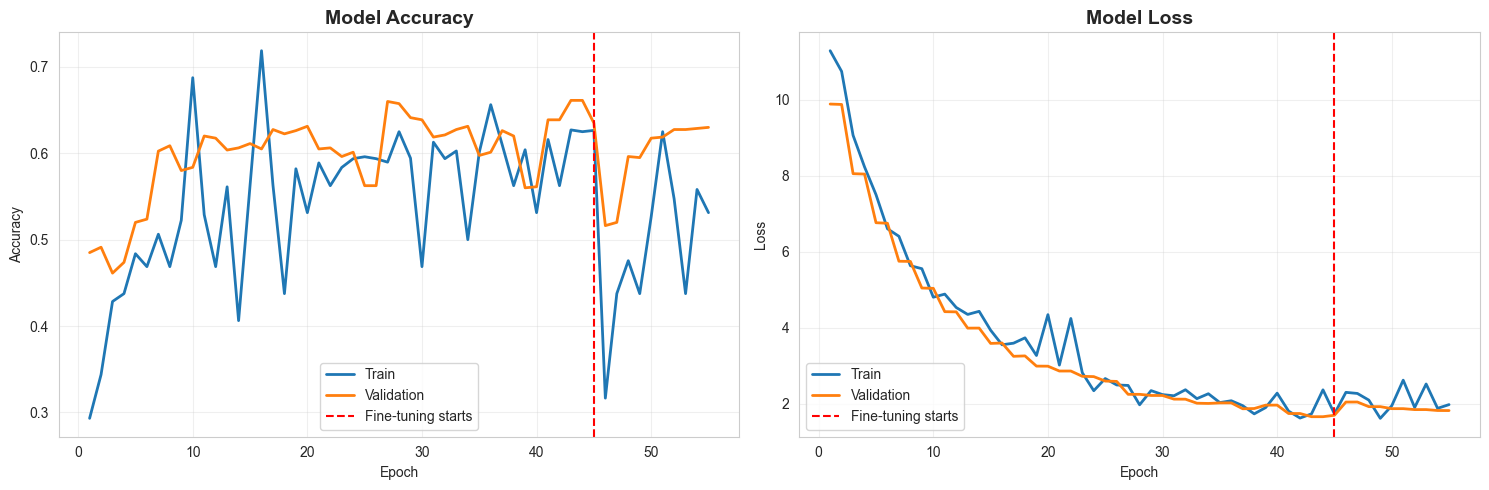

✓ Training history saved as 'training_history.png'


In [ ]:
# ============================================================================
# STEP 18: SAVE EVERYTHING
# ============================================================================

print("\n" + "="*80)
print("STEP 18: SAVING RESULTS")
print("="*80)

model.save('skin_cancer_final_improved.keras')
print("✓ Model saved as 'skin_cancer_final_improved.keras'")

# Save history
history_df = pd.DataFrame(combined_history)
history_df.to_csv('training_history_improved.csv', index=False)
print("✓ History saved")

# Save predictions
predictions_df = pd.DataFrame({
    'true_label': [class_names[i] for i in y_true_classes],
    'predicted_label': [class_names[i] for i in y_pred_classes],
    'predicted_label_tta': [class_names[i] for i in y_pred_tta_classes],
    'correct': y_pred_classes == y_true_classes,
    'correct_tta': y_pred_tta_classes == y_true_classes
})
predictions_df.to_csv('predictions_improved.csv', index=False)
print("✓ Predictions saved")

print("\n" + "="*80)
print("TRAINING COMPLETE!")
print("="*80)
print(f"Final Test Accuracy: {test_results[1]*100:.2f}%")
print(f"TTA Accuracy: {tta_accuracy*100:.2f}%")
print("="*80)